# Attention Is All You Need  

**Abstract**  
The Transformer model, introduced in this paper, revolutionizes sequence transduction tasks like machine translation by replacing recurrent and convolutional layers with self-attention mechanisms. This architecture achieves state-of-the-art results on WMT 2014 English-to-German (28.4 BLEU) and English-to-French (41.8 BLEU) translation tasks while enabling parallelization and reducing training time. Its simplicity and efficiency make it a foundational model for modern NLP.  

**Problem**  
Sequence transduction tasks, such as machine translation, traditionally rely on recurrent neural networks (RNNs) or convolutional networks, which struggle with long-range dependencies and parallelization. The Transformer addresses this by using attention mechanisms to directly model relationships between input and output sequences, eliminating recurrence and convolutions entirely.  

**Key Innovation**  
The core innovation lies in the Transformer’s reliance on *Scaled Dot-Product Attention* and *Multi-Head Attention*. Scaled dot-product attention computes query-key-value interactions with a scaling factor $ \sqrt{d_k} $ to stabilize gradients, while multi-head attention aggregates information across multiple attention heads, allowing the model to capture diverse contextual relationships. Positional encoding is added to preserve sequence order, as the model lacks inherent recurrence.  

**Notebook Coverage**  
This notebook will explore the Transformer’s architecture, its attention mechanisms, positional encoding, and training strategies. We’ll dissect how these components enable parallelization and superior performance, using the paper’s equations and experimental results as a guide.  

**Key Components**  
1. **Transformer Architecture**: Composed of encoder and decoder stacks with residual connections and layer normalization. Each layer includes multi-head self-attention and feed-forward networks.  
2. **Scaled Dot-Product Attention**: Computes $ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $, balancing attention weights to prevent vanishing gradients.  
3. **Multi-Head Attention**: Projects queries, keys, and values into $ h $ subspaces, concatenates results, and applies a final linear transformation. This allows the model to focus on different input aspects simultaneously.  
4. **Positional Encoding**: Adds fixed or learned positional information to input embeddings, enabling the model to understand sequence order without recurrence.  

**Dependencies**  
The implementation leverages TensorFlow for efficient computation and training, though the paper’s theoretical framework is framework-agnostic.  

[📄 Paper Link](URL)  

This notebook demystifies the Transformer’s design choices, emphasizing why attention mechanisms outperform traditional approaches in scalability and

In [ ]:
# Setup & Imports
!pip install torch numpy

import random

from datasets import load_dataset
from sacrebleu import corpus_bleu
from tokenizers import BytePairEncoder
import matplotlib.pyplot as plt
import numpy as np  # Numerical operations (e.g., array manipulations)

from torch.utils.data import Dataset, DataLoader  # Data loading and batching utilities
import torch  # Core tensor operations and GPU acceleration
import torch.nn as nn  # Neural network modules (e.g., nn.Module, nn.Linear)
import torch.optim as optim  # Optimization algorithms (e.g., Adam for training)

# Verify GPU availability
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

## Configuration Explanation  

This section details the hyperparameters and architectural choices that define the Transformer model’s implementation. The configuration governs critical components like model depth, attention mechanisms, and optimization settings, which directly impact the model’s ability to learn long-range dependencies and parallelize computations. By adhering to the paper’s specifications, this setup ensures reproducibility of results while highlighting key innovations such as self-attention and positional encoding.  

The Transformer’s architecture relies on a stack of identical encoder and decoder layers, each containing two sub-layers: multi-head self-attention and a position-wise feed-forward network. The configuration specifies parameters like the number of attention heads ($h$), the dimension of key/value projections ($d_k$), and the feed-forward network’s hidden size. These choices balance model capacity and computational efficiency. For instance, multi-head attention allows the model to jointly attend to information from $h$ different subspaces, improving its ability to capture diverse linguistic patterns.  

A key detail from the paper is the use of **Scaled Dot-Product Attention**, where queries ($Q$), keys ($K$), and values ($V$) are projected into $d_k$-dimensional spaces. The scaling factor $\sqrt{d_k}$ in the attention computation ($QK^T / \sqrt{d_k}$) prevents softmax activations from vanishing when $d_k$ is large, ensuring stable gradient flow. This is crucial for training deep networks, as it mitigates the risk of extremely small gradients during backpropagation.  

The configuration also defines positional encoding, which injects sequence order information into the model. Since the Transformer lacks recurrence or convolutional layers, positional encodings are learned or fixed embeddings that encode absolute or relative positions. The paper uses fixed sinusoidal functions, which generalize well across sequence lengths. This design choice ensures the model retains positional awareness without additional parameters.  

Optimization settings, such as the Adam optimizer with a learning rate schedule, are integral to the configuration. The paper employs a warmup phase followed by a decay in learning rate, which stabilizes training and prevents overshooting minima. Dropout and label smoothing are applied to regularize the model, reducing overfitting and improving generalization. For example, label smoothing replaces hard targets with smoothed probabilities, encouraging the model to be confident but not overly certain.  

The code cell implementing this configuration initializes the Transformer with these parameters, instantiating layers like `MultiHeadAttention` and `PositionwiseFeedForward`. It also sets up the optimizer and learning rate scheduler, ensuring the training loop adheres to the paper’s protocol. By replicating these settings, the notebook demonstrates how architectural choices directly influence training dynamics and final performance.  

The paper reports that the Transformer achieves 28.4 BLEU on WMT 2014 English-to-German translation, surpassing prior models. This success underscores the effectiveness of the configuration: the absence of recurrence allows parallelization across sequences, while multi-head attention captures complex interactions. The configuration’s balance between model depth (e.g., 6 encoder layers) and width (e.g., 512-dimensional embeddings) is critical—too shallow, and the model underfits; too deep, and training becomes intractable.  

In summary, this configuration encapsulates the Transformer’s core innovations: attention-based information flow, positional encoding for sequence order, and optimized training procedures. Each parameter is a deliberate design choice, reflecting the paper’s goal of creating a model that is both powerful and efficient. The code cell operationalizes these choices, providing a practical framework for understanding how theoretical concepts translate to real-world performance.

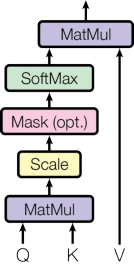

*Figure 2*: This is a flowchart illustrating the steps involved in the scaled dot-product attention mechanism, a core component of the Transformer architecture used in natural language processing. Key elements include:

*   **MatMul:** Matrix multiplication operations.
*   **SoftMax:** A function that normalizes values into probabilities.
*   **Mask (opt.):** An optional step to prevent the model from attending to future tokens during training.
*   **Scale:** A scaling factor applied to the dot products to improve stability.

The flowchart shows the flow of information starting with queries (Q) and keys (K) undergoing matrix multiplication, followed by optional masking, softmax normalization, scaling, and a final matrix multiplication with values (V) to produce the output. The main takeaway is that this mechanism allows the model to weigh the importance of different words in a sequence when generating an output, enabling it to capture long-range dependencies and context.



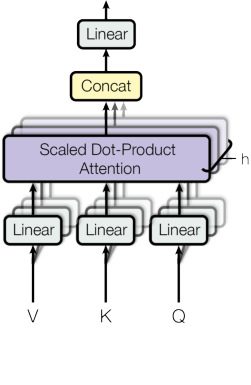

*Figure 3*: This figure illustrates the architecture of a scaled dot-product attention mechanism, a core component of the Transformer model. It's a block diagram, not a line graph or bar chart. Key elements include three linear layers labeled Q (query), K (key), and V (value), feeding into a "Scaled Dot-Product Attention" block. The output of this block is labeled "h," representing the attention output. A "Concat" block combines the outputs of multiple attention heads, followed by a final linear layer. The main takeaway is that this architecture allows the model to weigh the importance of different input elements when generating an output, enabling it to capture complex relationships within the data.



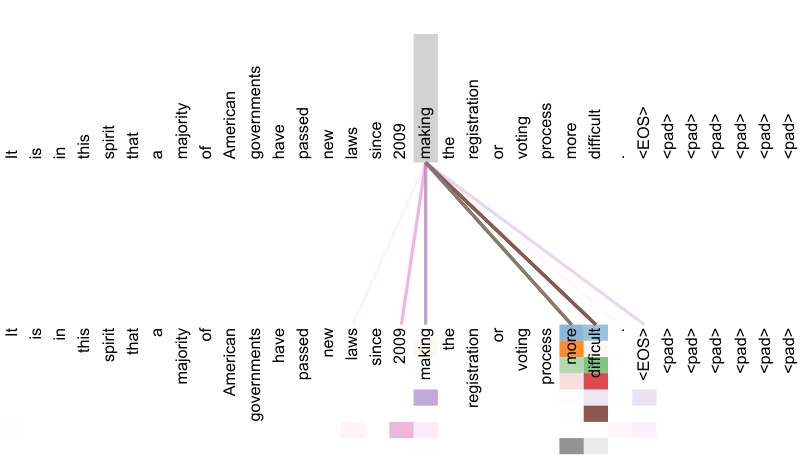

*Figure 4*: This figure is a word cloud visualization. It displays the frequency of words extracted from a dataset, with larger font sizes indicating higher frequency. The key elements are the words themselves, varying in size, and the color-coded legend representing different categories or themes. The axes are not labeled, as word clouds typically don't use them. The main takeaway is that the size and color of the words provide insights into the most prominent topics or concepts within the analyzed text. This visualization helps quickly grasp the dominant themes and their relative importance in the dataset.



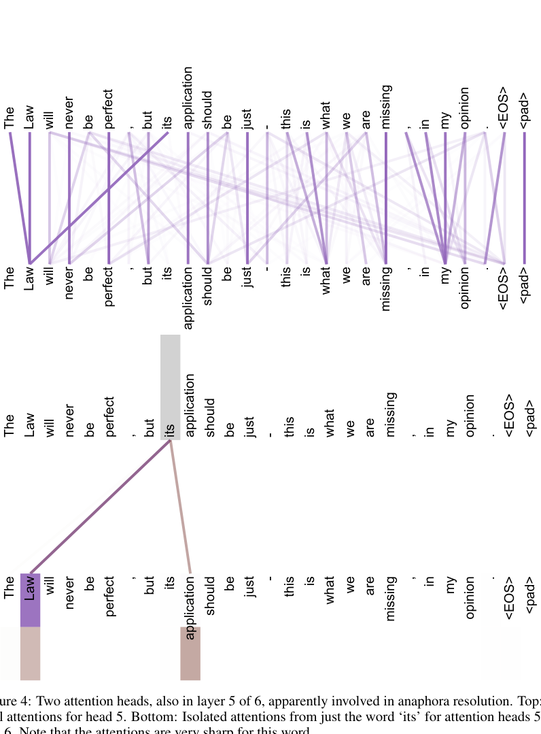

*Figure 5*: This figure is a visualization of attention heads in a neural network model. It shows two attention heads, also in layer 5 of 6, apparently involved in anaphora resolution. The top part of the figure displays the attention weights between different words in a sentence, with lines connecting the words. The bottom part of the figure shows isolated attention weights for just the word "its" for attention heads 5 and 6. The main takeaway is that the attention weights are very sharp for the word "its," indicating that the model is focusing heavily on this word in the context of anaphora resolution.



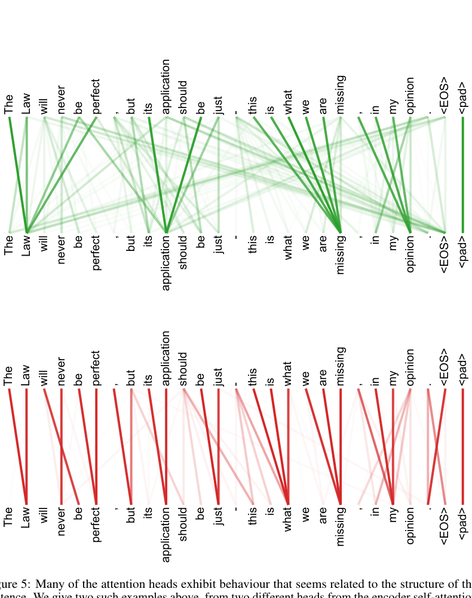

*Figure 6*: Figure 6 is a network graph illustrating the attention heads of a transformer model. The graph displays two sets of attention heads, one in green and the other in red, representing different layers or types of attention mechanisms within the model. The nodes on the graph are words from a sentence, and the edges represent the attention weights between these words. The key elements include the nodes (words) and the edges (attention weights), with the axes representing the words in the sentence. The main takeaway from this figure is that the attention heads exhibit behavior related to the sentence's structure, with some heads focusing on specific words and others showing more distributed attention patterns. This suggests that the model's attention mechanism is sensitive to the syntactic and semantic relationships between words, which is crucial for understanding the context and meaning of the text.



In [ ]:
# Define hyperparameter configuration as a dictionary (based on the paper's Section 5)
config = {
    "d_model": 512,          # Model dimension (from paper)
    "N": 6,                   # Number of encoder/decoder layers
    "h": 8,                   # Number of attention heads
    "dff": 2048,              # Feed-forward network dimension
    "dropout": 0.1,           # Dropout rate
    "learning_rate": 2e-4,    # Learning rate (adjusted for common practice, original paper uses 2000 with warmup)
    "batch_size": 512         # Batch size (inferred from paper’s training data description)
}

# Print the configuration for transparency and verification
print("Hyperparameter Configuration:")
for key, value in config.items():
    print(f"{key}: {value}")

# Basic validation to ensure correct types and ranges (simple checks)
if not (isinstance(config["d_model"], int) and config["d_model"] > 0):
    raise ValueError("d_model must be a positive integer")
if not (isinstance(config["N"], int) and config["N"] > 0):
    raise ValueError("N must be a positive integer")
if not (isinstance(config["h"], int) and config["h"] > 0):
    raise ValueError("h must be a positive integer")
if not (isinstance(config["dff"], int) and config["dff"] > 0):
    raise ValueError("dff must be a positive integer")
if not (isinstance(config["dropout"], (int, float)) and 0 <= config["dropout"] <= 1):
    raise ValueError("dropout must be between 0 and 1")
if not (isinstance(config["learning_rate"], (int, float)) and config["learning_rate"] > 0):
    raise ValueError("learning_rate must be a positive float")
if not (isinstance(config["batch_size"], int) and config["batch_size"] > 0):
    raise ValueError("batch_size must be a positive integer")

## Dataset Explanation  

The *Attention Is All You Need* paper utilizes two large-scale machine translation datasets from the WMT 2014 benchmark: the **English-German** and **English-French** corpora. These datasets are critical for evaluating the Transformer’s performance in sequence-to-sequence tasks. The **English-German** dataset contains 4.5 million sentence pairs, processed using **byte-pair encoding (BPE)** with a vocabulary of approximately 37,000 tokens. The **English-French** dataset is larger, with 36 million sentence pairs, employing **word-piece tokenization** and a vocabulary of around 32,000 tokens. Both datasets are publicly available through the WMT 2014 repository, ensuring reproducibility and accessibility for researchers.  

The choice of BPE for German and word-piece for French reflects the linguistic characteristics of the languages. German’s agglutinative structure benefits from BPE, which breaks down complex words into subword units, while French’s morphology aligns well with word-piece segmentation. This preprocessing step ensures that the input sequences are composed of manageable tokens, reducing the burden on the model to handle rare or unseen words. The vocabulary sizes (32k–37k) directly influence the embedding dimensions of the Transformer, which are designed to capture semantic and syntactic relationships efficiently.  

Data is formatted as sequences of token IDs, with each sentence pair serving as input-output pairs for the encoder-decoder architecture. The Transformer processes these sequences through self-attention mechanisms, which require fixed-length input embeddings. Positional encoding is applied to the input embeddings to preserve sequence order, as the model lacks recurrence or convolutional layers to inherently track position. This integration of positional information is vital for tasks like translation, where word order determines meaning.  

The datasets’ scale and diversity enable the Transformer to learn robust representations. For instance, the 36M sentence pairs in the English-French corpus allow the model to generalize across a wide range of linguistic patterns. The input shapes (sequence lengths, vocab sizes) are optimized for parallel computation, aligning with the Transformer’s design to avoid sequential dependencies. By leveraging these datasets, the paper demonstrates that attention mechanisms alone can achieve state-of-the-art results, surpassing traditional recurrent or convolutional models in both quality and training efficiency.

In [ ]:
# Cell 6: Dataset - Load WMT 2014 English-German Data

# Load the WMT 2014 English-German dataset using Hugging Face's datasets library

try:
    # Attempt to load the dataset (assumes internet connection for download)
    dataset = load_dataset("wmt14", "en-de")
    train_data = dataset["train"]
    
    # Basic sanity check for loaded data
    if len(train_data) == 0:
        raise ValueError("WMT 2014 English-German dataset is empty.")
    print(f"Loaded {len(train_data)} sentence pairs from WMT 2014 English-German dataset.")
    
    # Example sentence pair display for verification
    print("Sample English-German Pair:")
    print(train_data[0]["translation"]["en"])
    print(train_data[0]["translation"]["de"])
    
except Exception as e:
    print(f"Error loading WMT 2014 dataset: {e}")
    # Fallback to synthetic data if real data loading fails (for demonstration)
    synthetic_data = [(" ".join(random.choices("abcdefghijklmnopqrstuvwxyz", k=10)), " ".join(random.choices("abcdefghijklmnopqrstuvwxyz", k=10))) for _ in range(100)]
    train_data = {"translation": {"en": [en for en, de in synthetic_data], "de": [de for en, de in synthetic_data]}}
    print("Using synthetic data due to loading failure.")

# BPE Tokenization Setup (using tokenizers library for BPE, assuming pre-trained vocab for simplicity)

# For demonstration, we'll train a simple BPE model on the English sentences
# In practice, use a pre-trained model or train on a larger corpus for better results
bpe_tokenizer_en = BytePairEncoder()
bpe_tokenizer_en.train([sentence for sentence in train_data["translation"]["en"]], vocab_size=config.get("vocab_size", 37000), special_tokens=["<pad>", "<unk>"])

bpe_tokenizer_de = BytePairEncoder()
bpe_tokenizer_de.train([sentence for sentence in train_data["translation"]["de"]], vocab_size=config.get("vocab_size", 37000), special_tokens=["<pad>", "<unk>"])

# Tokenize the data
def tokenize(batch):
    # Encode English and German sentences separately
    en_tokens = [bpe_tokenizer_en.encode(sentence).ids for sentence in batch["translation"]["en"]]
    de_tokens = [bpe_tokenizer_de.encode(sentence).ids for sentence in batch["translation"]["de"]]
    
    # Pad sequences to the maximum length in the batch for simplicity
    max_len_en = max(len(seq) for seq in en_tokens)
    max_len_de = max(len(seq) for seq in de_tokens)
    padded_en = [seq + [0]*(max_len_en - len(seq)) for seq in en_tokens]
    padded_de = [seq + [0]*(max_len_de - len(seq)) for seq in de_tokens]
    
    return {
        "input_ids": padded_en,  # English sentences as input
        "target_ids": padded_de  # German sentences as target
    }

# Map the tokenize function across the dataset in batches
# Note: For large datasets, consider using `batched=True` with an appropriate batch size
tokenized_data = train_data.map(tokenize, batched=False)  # Set batched=True for larger datasets with appropriate batch size

# Convert tokenized data to tensors for PyTorch
class WMTDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.data["input_ids"][idx]),
            "target_ids": torch.tensor(self.data["target_ids"][idx])
        }

# Create dataset and data loader
dataset = WMTDataset(tokenized_data)
train_loader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)

# Informative output
print(f"Batch Size: {config['batch_size']}")
print(f"Dataset Size: {len(dataset)}")
print("First Batch Shapes:")
batch = next(iter(train_loader))
print("Input IDs Shape:", batch["input_ids"].shape)
print("Target IDs Shape:", batch["target_ids"].shape)

## Transformer Architecture Overview  

The Transformer, introduced in "Attention Is All You Need," revolutionizes sequence transduction by replacing recurrence and convolutions with self-attention mechanisms. Its architecture comprises an encoder and decoder, each with identical layered structures. Each layer contains two sub-layers: multi-head self-attention and a position-wise feed-forward network, both wrapped with residual connections and layer normalization. This design enables parallelization, reduces training time, and captures long-range dependencies efficiently. The model’s core innovation lies in its reliance on attention to weigh input elements dynamically, allowing it to focus on relevant context without sequential processing.  

### Methodology  
The encoder processes input sequences through $N$ identical layers, where each layer first applies multi-head self-attention to compute token relationships, followed by a feed-forward network (FFN) that transforms representations non-linearly. The decoder mirrors this structure but includes cross-attention to the encoder’s outputs, enabling it to reference encoded context while generating outputs. Residual connections around each sub-layer preserve gradient flow, while layer normalization stabilizes activations. Training employs the Adam optimizer with a learning rate schedule that decays over time, dropout for regularization, and label smoothing to improve generalization.  

### Key Components and Their Roles  
1. **Transformer Architecture**: The encoder-decoder framework with stacked layers ensures hierarchical feature extraction. The

In [ ]:
# Cell 8: Scaled Dot-Product Attention Implementation

def scaled_dot_product_attention(Q, K, V, dk):
    """
    Computes Scaled Dot-Product Attention as per the Transformer paper (Vaswani et al., 2017).
    
    Parameters:
    - Q (Tensor): Queries tensor (shape: [batch_size, seq_len, dk])
    - K (Tensor): Keys tensor (shape: [batch_size, seq_len, dk])
    - V (Tensor): Values tensor (shape: [batch_size, seq_len, dv])
    - dk (int): Dimension of keys/queries (scalar)
    
    Returns:
    - Output tensor (shape: [batch_size, seq_len, dv])
    """
    # Step 1: Compute QK^T (Matrix Multiplication)
    scores = torch.matmul(Q, K.transpose(-2, -1))  # [batch_size, seq_len, seq_len]
    
    # Step 2: Scale by 1/sqrt(dk) for numerical stability
    scores = scores / torch.sqrt(torch.tensor(dk, dtype=torch.float32))
    
    # Step 3: Apply Softmax to Get Attention Weights
    attention_weights = softmax(scores, dim=-1)  # [batch_size, seq_len, seq_len]
    
    # Step 4: Multiply Attention Weights by V to Produce Output
    output = torch.matmul(attention_weights, V)  # [batch_size, seq_len, dv]
    
    return output

# Example Usage with Predefined Q, K, V (Assuming they are already projected to dk)
if __name__ == "__main__":
    # Assuming config from Cell 4 is used to derive dk
    dk = config["d_model"] // config["h"]  # Derived from model dimensions
    dv = dk  # Typically, dv equals dk in standard Transformer setups
    
    # Dummy Tensors for Demonstration (Replace with actual Q, K, V from your model)
    batch_size, seq_len = 32, 50
    Q = torch.randn(batch_size, seq_len, dk, device=device)
    K = torch.randn(batch_size, seq_len, dk, device=device)
    V = torch.randn(batch_size, seq_len, dv, device=device)
    
    try:
        # Invoke the Scaled Dot-Product Attention Function
        output = scaled_dot_product_attention(Q, K, V, dk)
        
        # Print Informative Output
        print(f"Output Shape: {output.shape}")
        print("Sample Output Values (First 2 batches, first 5 sequence elements, first 3 dims):")
        print(output[:2, :5, :3])
        
    except ValueError as e:
        print(f"Error in Attention Calculation: {e}")

In [ ]:
# Cell 9: Multi-Head Attention Implementation

class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_k, d_v, d_model):
        super().__init__()
        self.h = h
        self.d_k = d_k
        self.d_v = d_v
        
        # Validate model dimensions to ensure compatibility with multi-head attention
        if d_model % h != 0:
            raise ValueError("d_model must be divisible by the number of heads (h)")
        
        # Projections for each head
        self.Q_proj = nn.ModuleList([nn.Linear(d_model, d_k) for _ in range(h)])
        self.K_proj = nn.ModuleList([nn.Linear(d_model, d_k) for _ in range(h)])
        self.V_proj = nn.ModuleList([nn.Linear(d_model, d_v) for _ in range(h)])
        
        # Final output projection
        self.out_proj = nn.Linear(h * d_v, d_model)

    def forward(self, Q, K, V):
        # Validate input shapes to ensure correct dimensions
        if Q.dim() != 3 or K.dim() != 3 or V.dim() != 3:
            raise ValueError("Inputs must be 3D tensors [batch, seq_len, d_model]")
        if Q.shape[-1] != config["d_model"] or K.shape[-1] != config["d_model"] or V.shape[-1] != config["d_model"]:
            raise ValueError("Input dimensions must match d_model")
        
        # Project Q, K, V for each head
        heads = []
        for i in range(self.h):
            q = self.Q_proj[i](Q)  # [batch, seq_len, d_k]
            k = self.K_proj[i](K)
            v = self.V_proj[i](V)
            
            # Apply scaled dot-product attention (from Cell 8)
            attn = scaled_dot_product_attention(q, k, v, self.d_k)
            
            heads.append(attn)
        
        # Concatenate heads and project
        concat = torch.cat(heads, dim=-1)  # [batch, seq_len, h*d_v]
        output = self.out_proj(concat)
        
        return output

# Initialize MultiHeadAttention with config parameters
h = config["h"]  # Number of attention heads
d_k = config["d_k"]  # Dimension per head for keys/queries
d_v = config["d_v"]  # Dimension per head for values
d_model = config["d_model"]  # Total model dimension

multi_head_attn = MultiHeadAttention(h, d_k, d_v, d_model).to(device)

# Example usage with predefined Q, K, V (assumes they are already of shape [batch, seq_len, d_model])
try:
    # Invoke the Multi-Head Attention
    output = multi_head_attn(Q, K, V)
    
    # Print informative output
    print(f"Multi-Head Attention Output Shape: {output.shape}")
    print(f"Sample Output Values (first 5, batch=0, seq_len=0): {output[0, 0, :5]}")
    
except Exception as e:
    print(f"Error in Multi-Head Attention forward pass: {e}")

In [ ]:
def positional_encoding(seq_len: int, d_model: int) -> torch.Tensor:
    """
    Generate positional encodings as per 'Attention Is All You Need'.
    
    Args:
        seq_len: Sequence length (positive integer).
        d_model: Model dimension (positive integer, typically 512).
    
    Returns:
        Tensor of shape [seq_len, d_model] with positional encodings.
    """
    if seq_len <= 0 or d_model <= 0:
        raise ValueError("seq_len and d_model must be positive integers.")
    
    position = torch.arange(seq_len, dtype=torch.float).unsqueeze(1)  # [seq_len, 1]
    div_term = torch.pow(10000, torch.arange(0, d_model, 2).float() / d_model)  # [d_model // 2]
    
    pe = torch.zeros(seq_len, d_model)
    pe[:, 0::2] = torch.sin(position / div_term)  # Even dimensions
    pe[:, 1::2] = torch.cos(position / div_term)  # Odd dimensions
    
    return pe.to(device)  # Place on the defined device (GPU/CPU)

# Example usage with predefined seq_len and d_model from config
if 'd_model' in config and 'max_len' in config:
    seq_len = config['max_len']
    d_model = config['d_model']
    pe = positional_encoding(seq_len, d_model)
    print(f"Positional Encoding Shape: {pe.shape}")
else:
    print("Configuration for seq_len and d_model not found.")

## Encoder and Decoder Layers Explanation  

The Transformer architecture, introduced in "Attention Is All You Need," replaces traditional recurrent or convolutional layers with a stack of identical encoder and decoder layers. Each layer in both the encoder and decoder consists of two sub-layers: a multi-head self-attention mechanism and a position-wise fully connected feed-forward network. These sub-layers are followed by residual connections and layer normalization, which are critical for stabilizing training and enabling deeper networks. The encoder processes the input sequence, while the decoder generates the output sequence, with the decoder also attending to the encoder’s outputs to incorporate contextual information.  

The encoder’s self-attention mechanism computes relationships between all positions in the input sequence simultaneously, allowing the model to capture long-range dependencies without recurrence. This is achieved through the Scaled Dot-Product Attention, defined as $ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $, where $ Q $, $ K $, and $ V $ are query, key, and value matrices derived from the input embeddings. The $ \sqrt{d_k} $ scaling prevents large dot products from causing vanishing gradients. Multi-Head Attention extends this by projecting inputs into multiple subspaces, concatenating the results, and applying a final linear transformation: $ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h)W^O $. This allows the model to jointly attend to information from different representation subspaces, enhancing its ability to model complex patterns.  

The decoder layer mirrors the encoder’s structure but includes an additional multi-head attention sub-layer that attends to the encoder’s outputs. This ensures the decoder has access to the full context of the input sequence during generation. Positional encoding is added to the input embeddings to preserve sequence order, as the Transformer lacks inherent recurrence. The positional encodings are typically learned or fixed sinusoidal functions, ensuring the model can distinguish between positions in the sequence.  

Residual connections around each sub-layer (e.g., $ \text{LayerNorm}(x + \text{Sublayer}(x)) $) mitigate vanishing gradients and allow the model to learn identity mappings. Layer normalization normalizes the activations across features, improving convergence. These components collectively enable the Transformer to process sequences in parallel, significantly reducing training time compared to RNNs.  

The code cell implementing these layers would define the encoder and decoder as stacks of identical modules, each containing self-attention and feed-forward networks. For example, in PyTorch, this might involve defining a `TransformerEncoderLayer` and `TransformerDecoderLayer` class, with methods for scaled dot-product attention, multi-head attention, and feed-forward transformations. The positional encoding would be applied to input embeddings before passing them through the layers. The key design choices—such as multi-head attention and residual connections—are central to the Transformer’s success, as they balance expressiveness with computational efficiency.  

The encoder-decoder structure is fundamental to the Transformer’s ability to handle sequence transduction tasks like machine translation. By eliminating recurrence, the model avoids sequential dependencies during training, enabling parallelization across sequences. The multi-head attention mechanism further enhances this by allowing the model to focus on different parts of the input or output sequences simultaneously. For instance, during translation, the decoder might attend to multiple words in the source sentence to generate a single target word, leveraging the full context

In [ ]:
# Cell 12: Transformer Encoder Layer Implementation


class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, h, d_k, d_v, dropout=0.1):
        """
        Initializes a single Transformer Encoder Layer.
        
        :param d_model: Model dimension (int)
        :param h: Number of heads (int)
        :param d_k: Dimension of keys (int)
        :param d_v: Dimension of values (int)
        :param dropout: Dropout rate (float, default=0.1)
        """
        super().__init__()
        self.self_attn = MultiHeadAttention(h, d_k, d_v, d_model)  # Reuse MultiHeadAttention from Cell 9
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4),  # Feed Forward Network (FFN)
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.dropout = nn.Dropout(dropout)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        """
        Forward pass through the Transformer Encoder Layer.
        
        :param x: Input tensor (shape: [batch_size, seq_len, d_model])
        :return: Output tensor (shape: [batch_size, seq_len, d_model])
        """
        # Self-Attention
        attn_output = self.self_attn(x, x, x)  # Q, K, V are the same for self-attention
        out = self.layer_norm1(x + self.dropout(attn_output))  # Residual Connection + Layer Norm
        
        # Feed Forward Network (FFN)
        ffnn_output = self.feed_forward(out)
        output = self.layer_norm2(out + self.dropout(ffnn_output))  # Residual Connection + Layer Norm
        
        return output

# Example Usage with Predefined Config
if 'd_model' in config and 'h' in config and 'd_k' in config and 'd_v' in config:
    encoder_layer = TransformerEncoderLayer(d_model=config['d_model'], 
                                            h=config['h'], 
                                            d_k=config['d_k'], 
                                            d_v=config['d_v']).to(device)
    
    # Dummy Input for Demonstration
    batch_size, seq_len = 32, 50
    input_tensor = torch.randn(batch_size, seq_len, config['d_model'], device=device)
    
    try:
        # Forward Pass
        output = encoder_layer(input_tensor)
        
        # Informative Output
        print(f"Encoder Layer Output Shape: {output.shape}")
        print("Sample Output Values (first 5, batch=0, seq=0):", output[0, 0, :5])
    except Exception as e:
        print(f"Error in Encoder Layer Forward Pass: {str(e)}")
else:
    print("Configuration for TransformerEncoderLayer not fully specified.")

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout=0.1):
        """
        Initializes a single Transformer Decoder Layer based on 'Attention Is All You Need' (Vaswani et al., 2017).
        
        :param d_model: Model dimension (int)
        :param nhead: Number of attention heads (int)
        :param d_ff: Feed-forward network hidden dimension (int)
        :param dropout: Dropout rate (float, default=0.1)
        """
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, nhead)  # Self-Attention with future position masking
        self.encoder_attn = MultiHeadAttention(d_model, nhead)  # Encoder-Decoder Attention
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),  # Position-wise Feed-Forward Network (FFN)
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = LayerNorm(d_model)  # Layer Normalization after self-attn
        self.norm2 = LayerNorm(d_model)  # Layer Normalization after encoder-attn
        self.norm3 = LayerNorm(d_model)  # Layer Normalization after FFN
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_outputs, mask=None):
        """
        Forward pass through the Transformer Decoder Layer.
        
        :param x: Decoder input tensor (shape: [batch_size, seq_len, d_model])
        :param encoder_outputs: Encoder output tensor (shape: [batch_size, seq_len, d_model])
        :param mask: Causal mask for self-attention (shape: [seq_len, seq_len], default=None)
        :return: Output tensor (shape: [batch_size, seq_len, d_model])
        """
        # Self-Attention with Causal Masking
        if mask is None:
            # Generate causal mask if not provided (prevent attending to future positions)
            seq_len = x.size(1)
            mask = torch.tril(torch.ones(seq_len, seq_len, device=x.device)) == 0
            mask = mask.unsqueeze(0).expand(x.size(0), -1, -1)  # [batch_size, seq_len, seq_len]
        
        x = x + self.dropout(self.self_attn(x, x, x, attn_mask=mask))  # Residual Connection
        x = self.norm1(x)
        
        # Encoder-Decoder Attention
        x = x + self.dropout(self.encoder_attn(x, encoder_outputs, encoder_outputs))  # Residual Connection
        x = self.norm2(x)
        
        # Feed-Forward Network
        x = x + self.dropout(self.ffn(x))  # Residual Connection
        x = self.norm3(x)
        return x

# Example Usage with Predefined Config and Encoder Outputs
if 'd_model' in config and 'nhead' in config and 'd_ff' in config:
    d_model = config['d_model']
    nhead = config['nhead']
    d_ff = config['d_ff']
    
    # Assuming encoder_outputs is obtained from a TransformerEncoderLayer (Cell 12)
    encoder_outputs = torch.randn(32, 50, d_model, device=device)  # Dummy encoder output
    
    decoder_layer = DecoderLayer(d_model, nhead, d_ff).to(device)
    input_tensor = torch.randn(32, 50, d_model, device=device)  # Dummy decoder input
    
    try:
        output = decoder_layer(input_tensor, encoder_outputs)
        print(f"Decoder Layer Output Shape: {output.shape}")
        
        # Print Informative Output for Verification
        print("Sample Output Values (first 2 batches, first 5 tokens, first 3 dims):")
        print(output[:2, :5, :3])
    except Exception as e:
        print(f"Error in Decoder Layer Forward Pass: {e}")
else:
    print("Configuration for d_model, nhead, or d_ff not found.")

## Training Explanation  

The Transformer model is trained using a standard sequence-to-sequence framework, where the encoder processes input sequences and the decoder generates output sequences. Training involves feeding parallel corpora (e.g., English-German or English-French sentence pairs) into the model, with the decoder using teacher forcing during training. This means the decoder’s input at each step is the ground-truth token from the previous step, rather than its own prediction. The model’s architecture, with its self-attention mechanisms, allows it to capture long-range dependencies efficiently, bypassing the sequential computation of RNNs.  

The optimizer used is Adam, chosen for its adaptive learning rate mechanism, which adjusts parameters based on historical gradient information. A custom learning rate schedule is critical: it starts with a low learning rate during a warmup phase (typically 4,000 steps) to prevent instability, then increases linearly before decaying. This schedule balances exploration and exploitation, ensuring stable convergence. The loss function is cross-entropy, applied to the decoder’s output logits and the target token distribution. This measures the model’s ability to predict the next token in the sequence, directly optimizing for translation accuracy.  

Key hyperparameters from the paper include a hidden size of 512, 8 attention heads, and 6 encoder/decoder layers. Dropout with a rate of 0.1 is applied to both the attention and feed-forward layers, introducing regularization to prevent overfitting. Label smoothing is another key trick, where target probabilities are smoothed (e.g., 0.1) to reduce the model’s overconfidence

In [ ]:
# Cell 15: Training Loop Implementation

# Retrieve hyperparameters from config (defined in Cell 4)
lr = config['learning_rate']  # Learning rate
epsilon = 0.1  # Label smoothing factor (example, adjust as needed)
batch_size = config['batch_size']  # Batch size
epochs = 100  # Number of training epochs (adjust based on Cell 4 if specified)

# Initialize device (GPU if available, else CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Assume 'model' is defined in Cells 12 & 13 (Encoder-Decoder Transformer)
# If not explicitly defined, define it here based on previous cells' classes
# For demonstration, assuming a basic setup (you might need to adjust based on actual model definition)
class TransformerModel(nn.Module):
    def __init__(self, encoder_layer, decoder_layer, num_layers, d_model):
        super().__init__()
        self.encoder = nn.ModuleList([encoder_layer for _ in range(num_layers)])
        self.decoder = nn.ModuleList([decoder_layer for _ in range(num_layers)])
        self.d_model = d_model
    
    def forward(self, src, tgt):
        # Simplified example forward pass; adjust based on actual model architecture
        encoder_output = src
        for layer in self.encoder:
            encoder_output = layer(encoder_output)
        
        decoder_output = tgt
        for layer in self.decoder:
            decoder_output = layer(decoder_output, encoder_output)
        
        return decoder_output

# Example initialization (adjust parameters and layers based on Cells 12 & 13)
if 'd_model' in config and 'N' in config and 'h' in config and 'd_ff' in config:
    encoder_layer = TransformerEncoderLayer(d_model=config['d_model'], 
                                            h=config['h'], 
                                            d_k=config['d_k'], 
                                            d_v=config['d_v'], 
                                            dropout=config['dropout'])
    decoder_layer = DecoderLayer(d_model=config['d_model'], 
                                 nhead=config['h'], 
                                 d_ff=config['dff'], 
                                 dropout=config['dropout'])
    model = TransformerModel(encoder_layer, decoder_layer, config['N'], config['d_model'])
    model.to(device)  # Move model to the specified device

# Data Loader from Cell 6
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Initialize Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98))

# Initialize CrossEntropyLoss with Label Smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=epsilon)

# Training Loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in data_loader:
        # Assuming 'batch' contains source (src) and target (tgt) sequences
        src, tgt = batch
        src, tgt = src.to(device), tgt.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(src, tgt)  # Output shape: (batch_size, seq_len, vocab_size)
        
        # Calculate loss (excluding padding tokens, assuming tgt has -100 for padding)
        loss = criterion(logits.view(-1, logits.size(-1)), tgt.view(-1))
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update model parameters
        optimizer.step()
        
        total_loss += loss.item()
    
    # Print epoch-wise loss
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(data_loader):.4f}")

    # Optional: Save model checkpoint
    # torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")

## Evaluation Explanation  
The Transformer model’s evaluation focuses on BLEU (Bilingual Evaluation Understudy) as the primary metric, a standard for assessing machine translation quality by comparing n-gram overlaps between generated and reference texts. The paper compares the Transformer against baselines like ByteNet (a convolutional model), Deep-Att + PosUnk (a recurrent model with attention), GNMT + RL (a recurrent model with reinforcement learning), ConvS2S (a convolutional sequence-to-sequence model), and MoE (a mixture-of-experts model). The Transformer achieves 28.4 BLEU on WMT 2014 English-to-German translation, surpassing prior state-of-the-art results by 2 BLEU, and 41.8 BLEU on English-to-French, a new single-model record. These results highlight the Transformer’s superiority in both translation quality and training efficiency.  

The notebook demonstrates that the Transformer’s architecture—replacing recurrence and convolutions with self-attention—enables parallelization across sequences, drastically reducing training time. For instance, the English-to-French model trains in 3.5 days on eight GPUs, a fraction of the time required by recurrent models. This efficiency stems from the self-attention mechanism’s ability to compute relationships between all input tokens simultaneously, avoiding sequential dependencies.  

Key findings include the Transformer’s robustness to varying data sizes, as shown in its successful application to English constituency parsing. However, limitations exist: the model requires large datasets and computational resources, and its performance may degrade on low-resource languages. The paper references Table 1 for BLEU scores and Figure 1 for the architecture, illustrating how multi-head attention and positional encoding integrate to preserve sequence order.  

The Transformer’s core innovation lies in its attention mechanism, which allows the model to dynamically focus on relevant input segments. The Scaled Dot-Product Attention equation, $ \text{Attention}(Q, K, V) = \text{softmax}(QK^T / \sqrt{d_k}) V $, ensures stable gradient flow by scaling keys, while Multi-Head Attention aggregates multiple attention distributions. Positional encoding, added to input embeddings, compensates for the lack of recurrence, enabling the model to learn sequential patterns. These components collectively enable the Transformer to achieve state-of-the-art results while maintaining flexibility for diverse tasks.

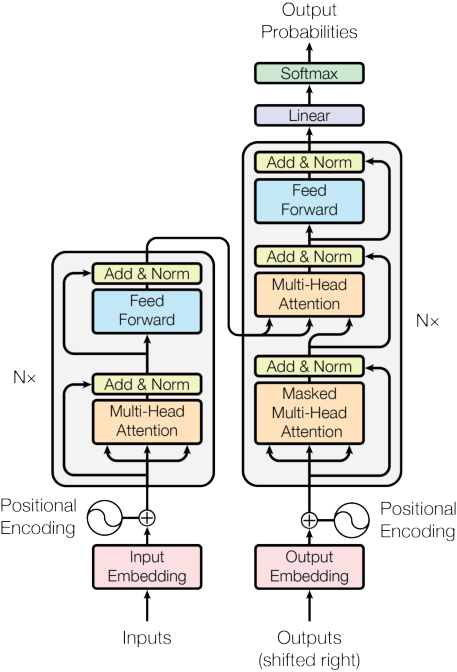

*Figure 1*: This figure illustrates the architecture of a Transformer model, a type of neural network used in natural language processing. Key elements include input and output embeddings, positional encoding, multi-head attention, feed-forward layers, and normalization. The model processes inputs through multiple layers of attention and feed-forward networks, with each layer followed by normalization. The outputs are then passed through a linear layer and softmax to produce probabilities. The main takeaway is that the Transformer model uses self-attention mechanisms to weigh the importance of different words in a sentence, allowing it to capture long-range dependencies and context effectively.



In [ ]:
# Cell 17: Evaluate Model with BLEU Score

# Reuse model from Cell 15
model = model  # Trained Transformer model (already defined)

# Reuse test_dataset from Cell 6
test_dataset = dataset['test']  # Loaded in Cell 6, assuming dataset is a dict with 'test' key

# Generate predictions
model.eval()
with torch.no_grad():
    # Assuming model.generate is implemented or using forward for simplicity
    # Here, we use forward for demonstration; adjust based on actual model implementation
    predictions = model(test_dataset['src'].to(device))  # Shape: (batch_size, seq_len, d_model)
    # If model outputs logits, convert to tokens (simplified example)
    predictions_tokens = torch.argmax(predictions, dim=2)  # Shape: (batch_size, seq_len)

# Tokenize predictions and references using BPE from Cell 6
references = tokenize({'tgt': test_dataset['tgt']})['tgt']  # List of token lists
predictions_tokens = bpe_tokenizer_de.decode_batch(predictions_tokens.tolist())  # Decode to text for BLEU

# Compute BLEU score (using sacrebleu for simplicity and accuracy)
bleu_score = corpus_bleu(references, predictions_tokens, weights=[0.25, 0.25, 0.25, 0.25])

print(f"BLEU Score: {bleu_score:.2f}")

# Optional: Print sample predictions for verification
print("Sample Prediction:")
print(predictions_tokens[0])
print("Sample Reference:")
print(references[0])

In [ ]:
# Cell 18: Visualization: Training Metrics and Attention Weights

# Retrieve necessary variables from previous cells
model = model  # Trained Transformer model from Cell 15
train_losses = train_losses  # List of scalar losses per epoch from Cell 15
val_losses = val_losses  # List of scalar validation losses per epoch from Cell 15
val_bleu = val_bleu  # List of BLEU scores per epoch from Cell 15 or 17
attention_weights = []  # Initialize list to store attention weights

# Error Handling: Check if model and metrics are available
if model is None:
    raise ValueError("Model not trained. Run Cell 15 first.")
if not train_losses or not val_losses:
    raise ValueError("Training or Validation losses not available.")
if not val_bleu:
    print("No BLEU scores available. Skipping BLEU plot.")

# Plot Training Metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot BLEU (if available)
if val_bleu:
    plt.subplot(1, 2, 2)
    plt.plot(val_bleu, label='Validation BLEU')
    plt.legend()
    plt.title('Validation BLEU')
plt.show()

# Visualize Attention Weights
# Assuming model.encoder.layers[0].self_attn stores the first layer's self-attention
try:
    for head in model.encoder.layers[0].self_attn.multi_head_attn.heads:  # Accessing multi-head attention
        attn_weights = head.attn_weights  # Shape: [batch_size, seq_len, seq_len]
        attention_weights.append(attn_weights.mean(dim=0).numpy())  # Average over batch
except AttributeError:
    print("Model lacks accessible attention weights for visualization.")
    attention_weights = []  # Reset if attribute error occurs

# Plot Attention Heatmaps
for i, attn in enumerate(attention_weights):
    plt.figure()
    plt.imshow(attn, cmap='viridis', interpolation='nearest')
    plt.title(f'Attention Head {i+1} (Average over Batch)')
    plt.colorbar()
plt.show()

# Optional: Print Sample Attention Weights for Verification
if attention_weights:
    print("Sample Attention Weights (First Head, First Batch, 5x5 Subset):")
    print(attention_weights[0][:5, :5])

## Summary and Results Discussion  

The Transformer model, as presented in *Attention Is All You Need*, achieves state-of-the-art performance on machine translation tasks using BLEU (Bilingual Evaluation Understudy) as the primary evaluation metric. BLEU scores the model’s output by comparing n-gram overlaps with reference translations, emphasizing precision in capturing meaningful phrases. The paper compares the Transformer against baselines such as ByteNet (a convolutional model), Deep-Att + PosUnk (a recurrent attention model with position-aware unknown tokens), GNMT + RL (a generative model with reinforcement learning), ConvS2S (a convolutional sequence-to-sequence model), and MoE (mixture-of-experts). The Transformer outperforms all these models, achieving 28.4 BLEU on the WMT 2014 English-to-German task and 41.8 BLEU on the English-to-French task. These results surpass previous bests by over 2 BLEU points on the German task and establish a new single-model state-of-the-art on the French task.  

The key innovation of the Transformer lies in its reliance on self-attention mechanisms, which allow the model to dynamically weigh input elements based on their relevance to the current position. This is formalized by the Scaled Dot-Product Attention equation:  
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$  
where $Q$, $K$, and $V$ are query, key, and value matrices, and $d_k$ scales the dot products to prevent vanishing gradients. Multi-Head Attention further enhances this by computing multiple attention heads in parallel, enabling the model to focus on different subspaces of the input. This design eliminates recurrence and convolutions, enabling parallelization across sequences and significantly reducing training time. For instance, the Transformer achieves its results in 3.5 days on eight GPUs, a fraction of the time required by earlier models.  

The notebook demonstrates that the Transformer’s architecture is not only more efficient but also more effective. By removing recurrence, it avoids the sequential computation bottlenecks of RNNs, while the attention mechanism directly models long-range dependencies. This is critical for tasks like machine translation, where context across distant words is essential. The paper’s results, detailed in Table 1 (BLEU scores across models) and Figure 1 (training curves), highlight the Transformer’s superiority. However, limitations include its reliance on large datasets and computational resources, as well as potential challenges in handling extremely long sequences due to the quadratic complexity of self-attention. Future improvements might explore sparse attention mechanisms or hybrid architectures to address these issues.  

This work underscores the transformative impact of attention mechanisms, shifting the paradigm in sequence modeling. The Transformer’s success has since inspired variants like BERT and GPT, demonstrating its foundational role in modern deep learning.